In [2]:
# env_name = 'Acrobot-v1'
env_name = 'ALE/Assault-ram-v5'

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import os
import time
import pickle
import ale_py


# Hyperparameters
EPISODES = 1000
MAX_STEPS = 1000
GAMMA = 0.99
HIDDEN_DIM = 256
SEEDS = 10

# Environment
env = gym.make(env_name)
env._max_episode_steps = MAX_STEPS

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "mps"

# Neural Network
class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, HIDDEN_DIM)
        self.fc2 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        self.fc3 = nn.Linear(HIDDEN_DIM, action_dim)

        # Initialize parameters
        for m in self.modules():
            if isinstance(m, nn.Linear):
                print("initializing layer", m)
                nn.init.uniform_(m.weight, -0.01, 0.01)
                nn.init.uniform_(m.bias, -0.01, 0.01)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Q-Learning
def q_learning(lr, batch_size, replay_buffer_size, epsilon):
    q_network = QNetwork()
    q_network_target = QNetwork()
    q_network_target.load_state_dict(q_network.state_dict())
    q_network.to(device)
    optimizer = optim.Adam(q_network.parameters(), lr=lr, eps=0.0003125)
    replay_buffer = deque(maxlen=replay_buffer_size)
    rewards = []
    for episode in range(EPISODES):
        state, info = env.reset()
        done = False
        total_reward = 0
        while not done:
            with torch.no_grad():
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                    action = q_network(state_tensor).argmax().item()
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                total_reward += reward
                replay_buffer.append((state, action, reward, next_state, done))
            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
                state_batch = torch.tensor(np.array(state_batch), dtype=torch.float32).to(device)
                action_batch = torch.tensor(np.array(action_batch), dtype=torch.long).to(device)
                reward_batch = torch.tensor(np.array(reward_batch), dtype=torch.float32).to(device)
                next_state_batch = torch.tensor(np.array(next_state_batch), dtype=torch.float32).to(device)
                done_batch = torch.tensor(np.array(done_batch), dtype=torch.float32).to(device)
                q_values = q_network(state_batch)
                next_q_values = q_network_target(next_state_batch)
                # next_q_values = q_network(next_state_batch)
                target_q_values = q_values.clone()
                # for i in range(batch_size):
                #     target_q_values[i][action_batch[i]] = reward_batch[i] + GAMMA * next_q_values[i].max() * (1 - done_batch[i])
                target_q_values[range(batch_size), action_batch] = reward_batch + GAMMA * next_q_values.max(dim=1).values * (1 - done_batch)
                loss = nn.MSELoss()(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            state = next_state
        rewards.append(total_reward)
        if episode % 10 == 0:
            q_network_target.load_state_dict(q_network.state_dict())
            print(episode, total_reward, loss.item())

    return rewards

# Expected SARSA
def expected_sarsa(lr, batch_size, replay_buffer_size, epsilon):
    q_network = QNetwork()
    q_network_target = QNetwork()
    q_network_target.load_state_dict(q_network.state_dict())
    optimizer = optim.Adam(q_network.parameters(), lr=lr, eps=0.0003125)
    replay_buffer = deque(maxlen=replay_buffer_size)
    rewards = []
    for episode in range(EPISODES):
        state, info = env.reset()
        done = False
        total_reward = 0
        while not done:
            with torch.no_grad():
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                    action = q_network(state_tensor).argmax().item()
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                total_reward += reward
                replay_buffer.append((state, action, reward, next_state, done))
            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
                state_batch = torch.tensor(np.array(state_batch), dtype=torch.float32).to(device)
                action_batch = torch.tensor(np.array(action_batch), dtype=torch.long).to(device)
                reward_batch = torch.tensor(np.array(reward_batch), dtype=torch.float32).to(device)
                next_state_batch = torch.tensor(np.array(next_state_batch), dtype=torch.float32).to(device)
                done_batch = torch.tensor(np.array(done_batch), dtype=torch.float32).to(device)
                q_values = q_network(state_batch)
                next_q_values = q_network_target(next_state_batch)
                # next_q_values = q_network(next_state_batch)
                target_q_values = q_values.clone()
                # expected sarsa
                probs = torch.ones(batch_size, action_dim) * epsilon / action_dim
                probs[range(batch_size), next_q_values.argmax(dim=1)] += 1 - epsilon
                target_q_values[range(batch_size), action_batch] = reward_batch + GAMMA * (probs * next_q_values).sum(dim=1) * (1 - done_batch)

                loss = nn.MSELoss()(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            state = next_state
        rewards.append(total_reward)
        if episode % 10 == 0:
            q_network_target.load_state_dict(q_network.state_dict())
            print(episode, total_reward, loss.item())
    return rewards


def run_experiment(lr, batch_size, replay_buffer_size, epsilon, seeds):
    random_seeds = [0, 1, 2, 3, 4, 5, 6, 8, 11, 12]
    print(seeds)
    q_learning_rewards = np.zeros((seeds, EPISODES))
    expected_sarsa_rewards = np.zeros((seeds, EPISODES))
    if os.path.exists(f'q_learning_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl'):
        old_q_learning_rewards = pickle.load(open(f'q_learning_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl', 'rb'))
        q_learning_rewards[:min(old_q_learning_rewards.shape[0], seeds)] = old_q_learning_rewards[:min(old_q_learning_rewards.shape[0], seeds)]
    if os.path.exists(f'expected_sarsa_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl'):
        old_expected_sarsa_rewards = pickle.load(open(f'expected_sarsa_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl', 'rb'))
        expected_sarsa_rewards[:min(old_expected_sarsa_rewards.shape[0], seeds)] = old_expected_sarsa_rewards[:min(old_expected_sarsa_rewards.shape[0], seeds)]
    # for i, seed in enumerate(random_seeds):
    for i in range(seeds):
        print(f'Run {i+1}/{seeds}')
        if q_learning_rewards[i].sum() == 0:
            print('Q-Learning')
            q_learning_rewards[i] = q_learning(lr, batch_size, replay_buffer_size, epsilon)
            pickle.dump(q_learning_rewards, open(f'q_learning_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl', 'wb'))
        if expected_sarsa_rewards[i].sum() == 0:
            print('Expected SARSA')
            expected_sarsa_rewards[i] = expected_sarsa(lr, batch_size, replay_buffer_size, epsilon)
            pickle.dump(expected_sarsa_rewards, open(f'expected_sarsa_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl', 'wb'))
        q_learning_rewards_mean = q_learning_rewards[:i+1].mean(axis=0)
        q_learning_rewards_std = q_learning_rewards[:i+1].std(axis=0)
        expected_sarsa_rewards_mean = expected_sarsa_rewards[:i+1].mean(axis=0)
        expected_sarsa_rewards_std = expected_sarsa_rewards[:i+1].std(axis=0)
        plt.plot(q_learning_rewards_mean, label='Q-Learning', color='green')
        plt.fill_between(range(EPISODES), q_learning_rewards_mean - q_learning_rewards_std, q_learning_rewards_mean + q_learning_rewards_std, color='green', alpha=0.2)
        plt.plot(expected_sarsa_rewards_mean, label='Expected SARSA', color='red')
        plt.fill_between(range(EPISODES), expected_sarsa_rewards_mean - expected_sarsa_rewards_std, expected_sarsa_rewards_mean + expected_sarsa_rewards_std, color='red', alpha=0.2)
        plt.title(f'lr={lr}, batch_size={batch_size}, replay_buffer_size={replay_buffer_size}, epsilon={epsilon}')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()
        plt.savefig(f'plot_{i}_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.png')
        plt.show()

/Users/Ile-Maurice/Library/Python/3.10/lib/python/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


0.0001 32 1000000 0.25
1
Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


0 168.0 0.01642978936433792
10 210.0 0.1288556009531021
20 189.0 0.5740059018135071
30 357.0 1.2379753589630127
40 315.0 0.0922442153096199
50 336.0 1.2343467473983765
60 252.0 0.1320044994354248
70 168.0 2.9359757900238037
80 378.0 1.5882337093353271
90 294.0 0.5540522336959839
100 294.0 0.2845838665962219
110 420.0 0.6596562266349792
120 273.0 1.1668167114257812
130 315.0 0.1166243776679039
140 525.0 0.1415644735097885
150 210.0 0.12989956140518188
160 252.0 4.364279747009277
170 273.0 1.4754880666732788
180 294.0 0.9875468015670776
190 189.0 2.6248056888580322
200 189.0 0.25055620074272156
210 378.0 0.2669732868671417
220 483.0 0.2082732617855072
230 315.0 0.16436098515987396
240 462.0 1.4893873929977417
250 231.0 0.2852856516838074
260 378.0 0.18065032362937927
270 357.0 0.19942720234394073
280 378.0 1.5866641998291016
290 189.0 1.6707677841186523
300 231.0 1.2748106718063354
310 147.0 2.339831829071045
320 378.0 0.3614143431186676
330 210.0 0.35882946848869324
340 252.0 0.18414117

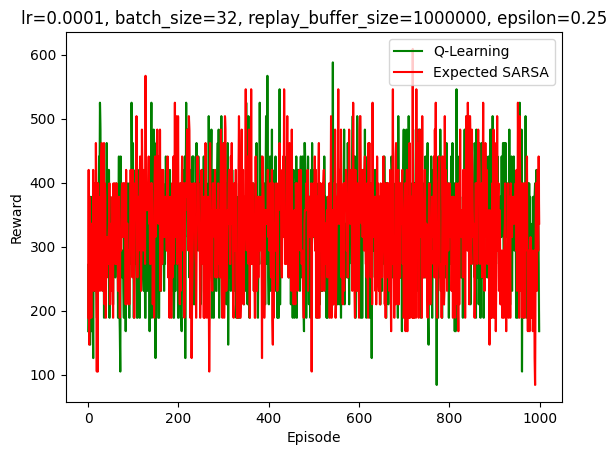

0.0001 32 1000000 0.1
1
Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 189.0 2.36244797706604
10 189.0 0.30170565843582153
20 462.0 0.9765791893005371
30 294.0 0.17941972613334656
40 189.0 1.2891340255737305
50 231.0 0.12271197140216827
60 273.0 1.0620784759521484
70 252.0 1.199004054069519
80 399.0 0.43400004506111145
90 378.0 0.3216707110404968
100 189.0 2.876380443572998
110 357.0 0.5134294033050537
120 357.0 0.9769402742385864
130 273.0 1.2730998992919922
140 336.0 1.1976263523101807
150 231.0 0.21927015483379364
160 294.0 0.17706820368766785
170 336.0 0.7382874488830566
180 378.0 0.3694

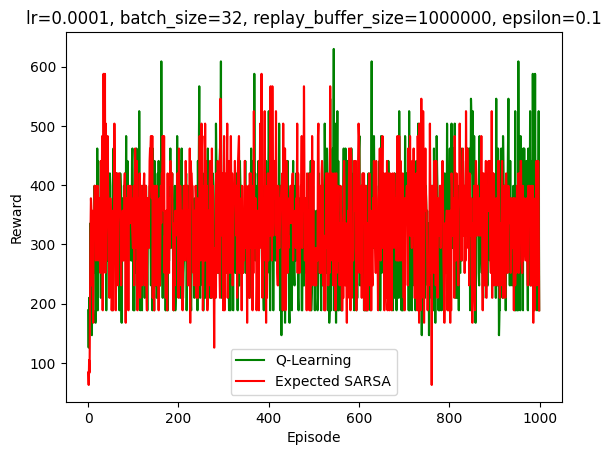

0.0001 32 1000000 0.01
1
Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 273.0 0.00537495594471693
10 210.0 0.10657820850610733
20 336.0 0.08234996348619461
30 189.0 1.3627737760543823
40 294.0 2.0207648277282715
50 336.0 0.5137397050857544
60 168.0 0.19613967835903168
70 357.0 0.5766257047653198
80 315.0 0.28028813004493713
90 420.0 1.612669825553894
100 273.0 1.2951751947402954
110 252.0 0.7602842450141907
120 357.0 0.318804532289505
130 441.0 1.3763307332992554
140 231.0 0.15476667881011963
150 336.0 0.7936558127403259
160 315.0 0.08965758979320526
170 315.0 0.12782448530197144
180 378.0 0

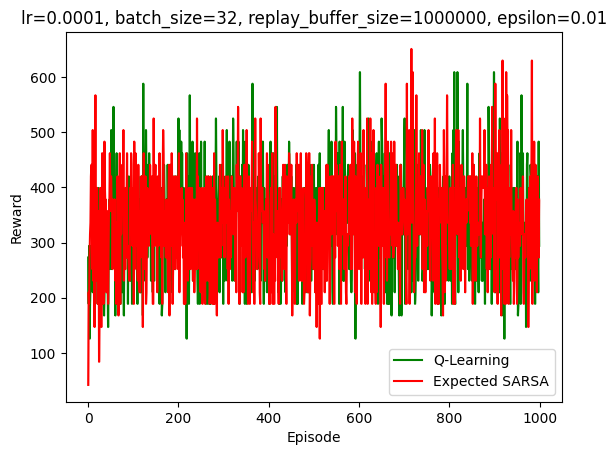

0.001 32 1000000 0.25
1
Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 210.0 1.9485251903533936
10 63.0 1.733014702796936
20 336.0 1.7425323724746704
30 441.0 1.9712754487991333
40 252.0 2.521094560623169
50 294.0 1.8099397420883179
60 504.0 0.6867343187332153
70 294.0 0.152506485581398
80 462.0 3.0107905864715576
90 462.0 2.6815154552459717
100 441.0 0.4375416934490204
110 567.0 1.0804270505905151
120 399.0 0.9173431992530823
130 147.0 0.27980712056159973
140 399.0 0.24487312138080597
150 441.0 0.9845560789108276
160 378.0 0.3813520073890686
170 399.0 0.17639991641044617
180 336.0 0.9525727

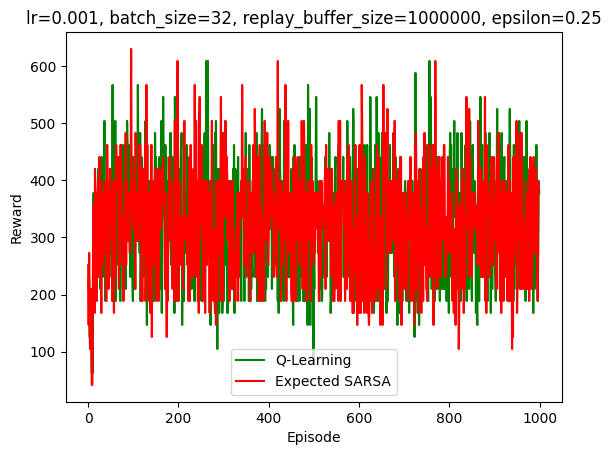

0.001 32 1000000 0.1
1
Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 336.0 0.046749215573072433
10 273.0 0.3821712136268616
20 294.0 1.4998836517333984
30 294.0 1.5494593381881714
40 252.0 0.1173129752278328
50 462.0 0.2901849150657654
60 420.0 0.2150225192308426
70 273.0 1.2877070903778076
80 399.0 1.3258672952651978
90 294.0 0.17144806683063507
100 210.0 0.49118804931640625
110 357.0 1.674944519996643
120 294.0 1.3358075618743896
130 168.0 0.14899007976055145
140 252.0 2.559277057647705
150 189.0 0.8603499531745911
160 420.0 1.1254006624221802
170 189.0 2.543973207473755
180 378.0 0.36027

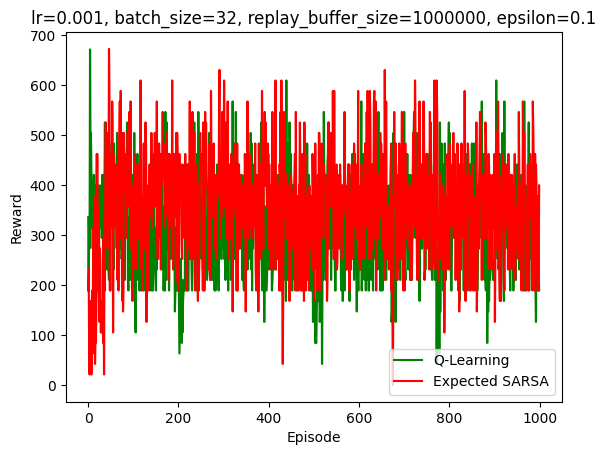

0.001 32 1000000 0.01
1
Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 0.0 2.3835525553295156e-06
10 609.0 1.869702696800232
20 399.0 0.026242075487971306
30 441.0 0.0960809662938118
40 336.0 1.8948687314987183
50 336.0 1.8950051069259644
60 378.0 0.0748695656657219
70 294.0 7.351242542266846
80 420.0 0.055942390114068985
90 462.0 0.0739399790763855
100 420.0 1.9019050598144531
110 357.0 0.05719861015677452
120 483.0 1.903451919555664
130 420.0 0.05533995106816292
140 504.0 5.900851249694824
150 441.0 1.9137582778930664
160 399.0 0.05165093019604683
170 294.0 3.773746967315674
180 231.0 5.61

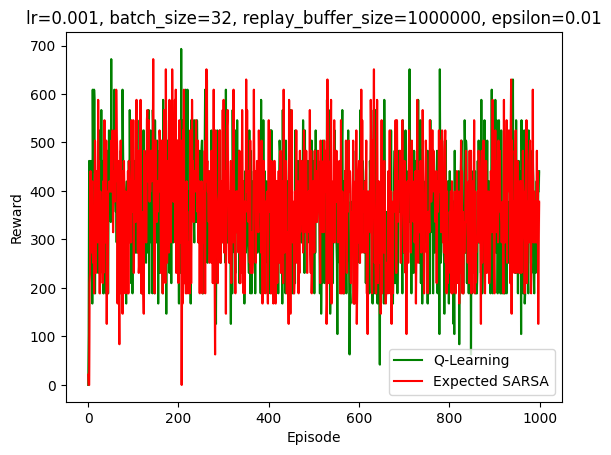

0.01 32 1000000 0.25
1
Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 399.0 1.8895483016967773
10 210.0 1.905166745185852
20 252.0 1.8770151138305664
30 609.0 7.484341144561768
40 399.0 3.8635826110839844
50 336.0 0.042818572372198105
60 378.0 0.03410736098885536
70 336.0 0.056949879974126816
80 525.0 0.048469431698322296
90 441.0 1.9723979234695435
100 231.0 3.8102214336395264
110 336.0 0.02778705582022667
120 420.0 0.04851033166050911
130 252.0 1.8966060876846313
140 399.0 0.06161149963736534
150 210.0 1.8929239511489868
160 294.0 3.8065836429595947
170 399.0 1.9522695541381836
180 315.0 1

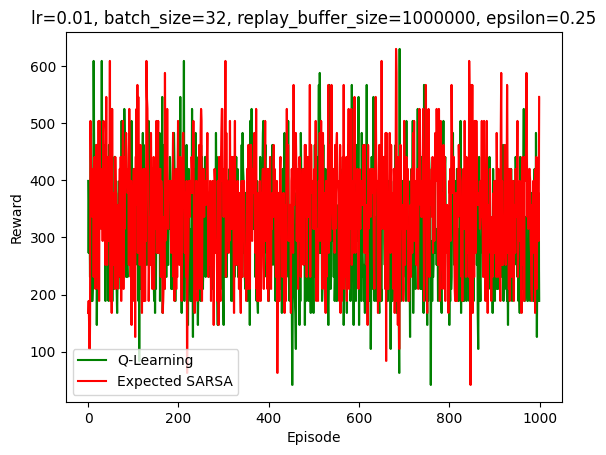

0.01 32 1000000 0.1
1
Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 441.0 1.8599737882614136
10 441.0 3.7516674995422363
20 462.0 7.476649284362793
30 462.0 0.05075150728225708
40 357.0 1.906740427017212
50 420.0 0.07448285073041916
60 189.0 3.7318971157073975
70 252.0 5.684578895568848
80 525.0 3.858792543411255
90 273.0 0.057431187480688095
100 441.0 0.08331723511219025
110 315.0 3.8091812133789062
120 294.0 0.045224931091070175
130 273.0 3.750169038772583
140 294.0 1.890753984451294
150 294.0 0.04756495729088783
160 126.0 1.907577395439148
170 525.0 1.8890883922576904
180 357.0 1.9448881

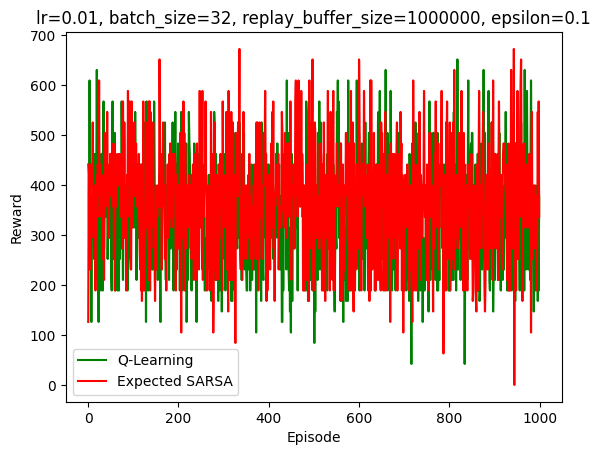

0.01 32 1000000 0.01
1
Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 42.0 0.0007777276332490146
10 504.0 1.8709497451782227
20 441.0 0.0409061424434185
30 399.0 5.627079963684082
40 399.0 5.617007255554199
50 315.0 1.899734616279602
60 273.0 7.4877028465271
70 399.0 0.07695071399211884
80 189.0 0.06131165474653244
90 525.0 1.9052512645721436
100 399.0 3.7503244876861572
110 399.0 1.9053256511688232
120 504.0 2.1695005893707275
130 252.0 1.903251051902771
140 462.0 1.9075090885162354
150 168.0 3.7462222576141357
160 588.0 3.7421185970306396
170 462.0 0.06501615792512894
180 189.0 0.080444850

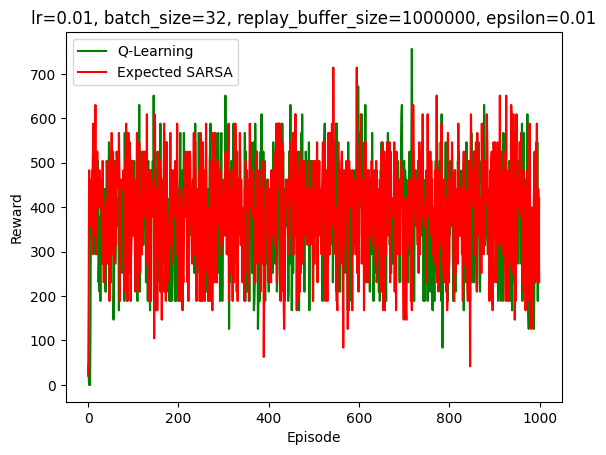

0.0001 1 1 0.25
1
Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 147.0 0.026873154565691948
10 168.0 0.06108643487095833
20 189.0 0.089293472468853
30 252.0 0.10189849883317947
40 315.0 0.644154965877533
50 273.0 0.5754843354225159
60 357.0 0.41333630681037903
70 273.0 1.5091354846954346
80 210.0 1.4030214548110962
90 420.0 0.11234543472528458
100 462.0 3.2134487628936768
110 483.0 2.053473949432373
120 189.0 0.7234274744987488
130 504.0 12.865991592407227
140 651.0 18.16933822631836
150 357.0 5.094433307647705
160 441.0 22.246740341186523
170 315.0 38.090919494628906
180 210.0 11.5933132171

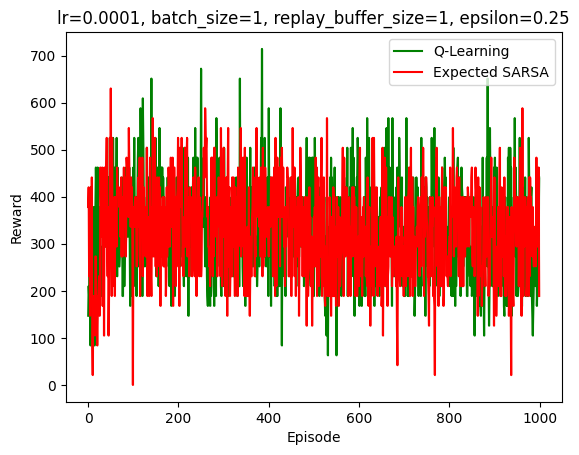

0.0001 1 1 0.1
1
Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 378.0 0.012206950224936008
10 126.0 0.005546974949538708
20 294.0 6.48514469503425e-05
30 273.0 0.0015051569789648056
40 378.0 0.0001987012365134433
50 189.0 0.001579851028509438
60 189.0 0.007179332431405783
70 252.0 0.10593993961811066
80 441.0 0.08656169474124908
90 441.0 0.03287187218666077
100 357.0 0.8983761668205261
110 399.0 3.2379684448242188
120 399.0 0.2512313425540924
130 504.0 7.128827095031738
140 420.0 4.014187812805176
150 399.0 0.7155812382698059
160 399.0 0.6871419548988342
170 399.0 0.6497880816459656
180 336.

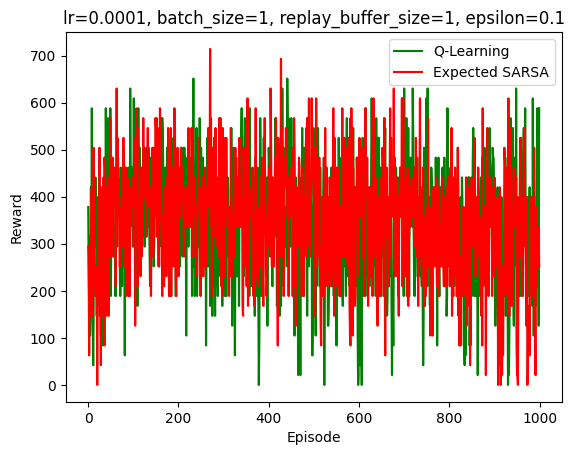

0.0001 1 1 0.01
1
Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 105.0 9.208001756633166e-06
10 126.0 0.01792050711810589
20 252.0 0.017374955117702484
30 0.0 0.016080845147371292
40 63.0 0.01104036532342434
50 441.0 0.026412488892674446
60 189.0 0.007838604040443897
70 462.0 0.008437630720436573
80 546.0 0.05352665111422539
90 210.0 0.030163029208779335
100 399.0 0.10032839328050613
110 420.0 0.7030969262123108
120 441.0 3.426356077194214
130 189.0 0.15761494636535645
140 462.0 2.4833741188049316
150 546.0 3.0358221530914307
160 441.0 2.9352455139160156
170 420.0 0.5252876877784729
180 420.

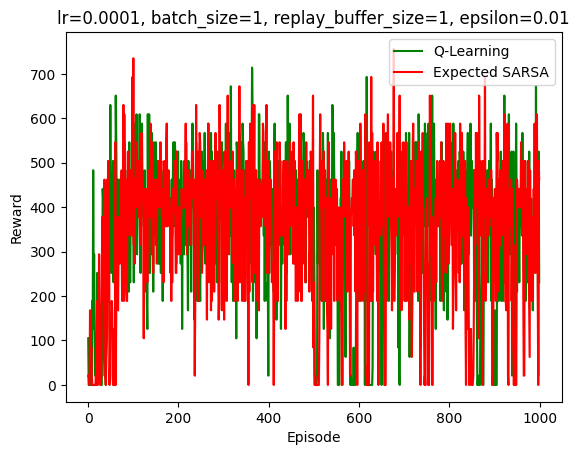

0.001 1 1 0.25
1
Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 357.0 0.00499650789424777
10 441.0 0.058513544499874115
20 63.0 0.14853902161121368
30 189.0 0.25670474767684937
40 399.0 0.31766802072525024
50 231.0 0.8034799695014954
60 105.0 0.7551022171974182
70 189.0 1.3379442691802979
80 357.0 1.9264298677444458
90 378.0 2.9279797077178955
100 210.0 2.7437102794647217
110 462.0 3.5305192470550537
120 168.0 3.61857008934021
130 147.0 3.652259349822998
140 210.0 3.7780072689056396
150 168.0 4.234825611114502
160 105.0 4.69733190536499
170 210.0 5.3906121253967285
180 378.0 6.38406229019165

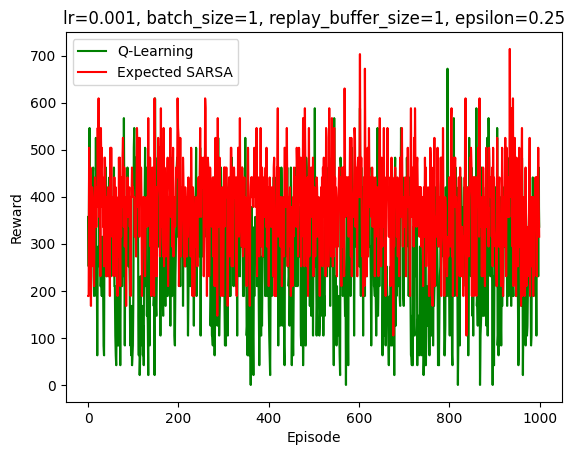

0.001 1 1 0.1
1
Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 399.0 0.0006547487573698163
10 462.0 0.03778744116425514
20 441.0 0.1392812281847
30 483.0 0.305957555770874
40 399.0 0.5568209886550903
50 504.0 0.8907449841499329
60 504.0 1.2851006984710693
70 546.0 1.7500606775283813
80 189.0 2.2239491939544678
90 378.0 2.824678659439087
100 399.0 3.4338791370391846
110 399.0 1.603699803352356
120 483.0 4.918100833892822
130 273.0 5.693846702575684
140 315.0 3.0762827396392822
150 462.0 7.605143070220947
160 273.0 8.548431396484375
170 399.0 9.624907493591309
180 336.0 10.751472473144531
190 

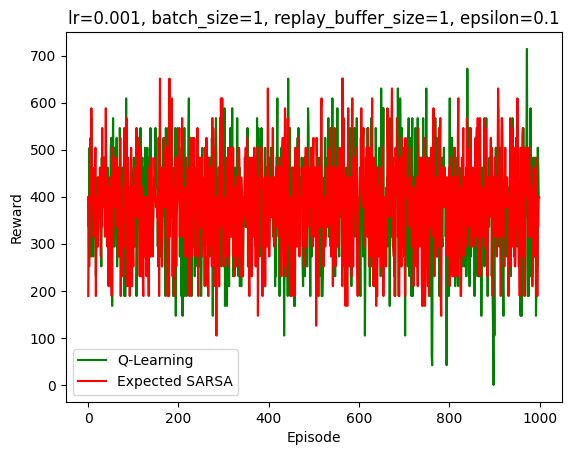

0.001 1 1 0.01
1
Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 0.0 0.00024341481912415475
10 21.0 0.0006616124301217496
20 189.0 0.01124204695224762
30 294.0 0.09040661156177521
40 504.0 0.24238136410713196
50 252.0 0.459385484457016
60 231.0 0.7353253364562988
70 483.0 1.1154872179031372
80 399.0 1.5754988193511963
90 420.0 2.118762254714966
100 399.0 2.7502312660217285
110 273.0 3.337303638458252
120 504.0 4.081116199493408
130 399.0 4.849262714385986
140 294.0 5.758578300476074
150 546.0 6.592272758483887
160 588.0 7.600226402282715
170 315.0 8.522826194763184
180 504.0 9.54538631439209


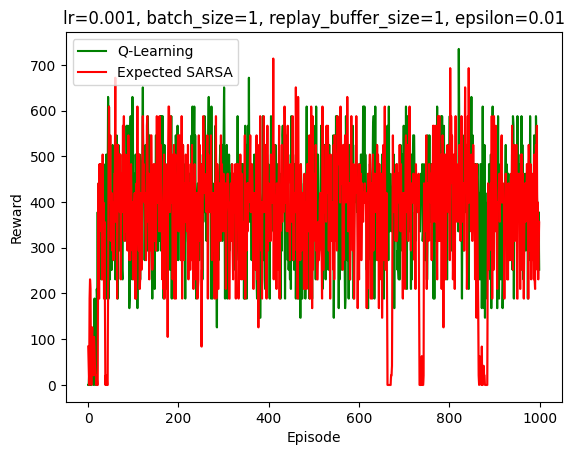

0.01 1 1 0.25
1
Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 63.0 1.2731092283502221e-05
10 147.0 0.0259995199739933
20 336.0 0.10098621994256973
30 441.0 0.35806289315223694
40 399.0 0.5877144932746887
50 588.0 0.9593158960342407
60 315.0 1.4437637329101562
70 525.0 2.0876128673553467
80 378.0 2.5836989879608154
90 525.0 3.1660072803497314
100 252.0 3.4684531688690186
110 189.0 4.337836265563965
120 336.0 5.441424369812012
130 273.0 5.620090484619141
140 273.0 6.76629638671875
150 357.0 7.956299304962158
160 399.0 10.731986999511719
170 462.0 11.706934928894043
180 210.0 12.16358089447021

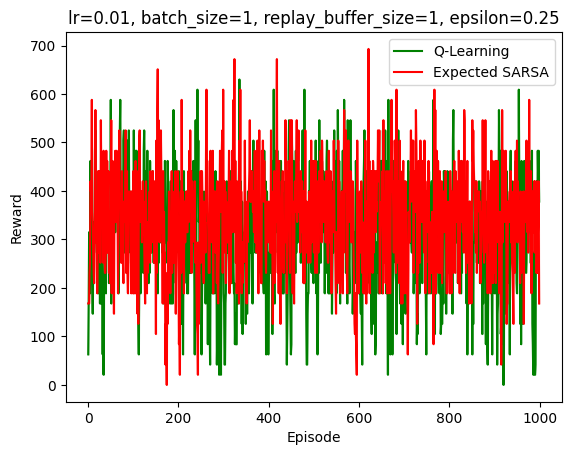

0.01 1 1 0.1
1
Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 189.0 0.0009305880521424115
10 189.0 0.06344154477119446
20 0.0 0.06276986747980118
30 399.0 0.17236599326133728
40 546.0 0.4518829882144928
50 357.0 0.508499026298523
60 441.0 1.3996450901031494
70 399.0 1.9627948999404907
80 294.0 2.5331311225891113
90 294.0 3.355355739593506
100 315.0 4.162283420562744
110 315.0 4.777527332305908
120 357.0 5.9818878173828125
130 483.0 6.244410991668701
140 294.0 8.13903522491455
150 441.0 9.110330581665039
160 252.0 9.559798240661621
170 168.0 11.276795387268066
180 357.0 12.604985237121582
190

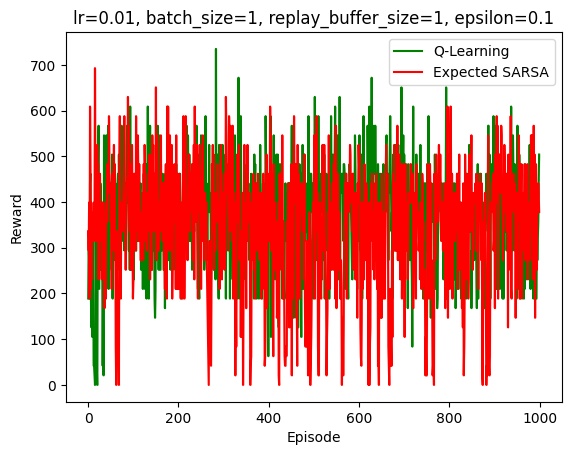

0.01 1 1 0.01
1
Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 84.0 0.06145169958472252
10 273.0 0.29322806000709534
20 0.0 0.28523150086402893
30 483.0 0.6197682023048401
40 273.0 0.905227780342102
50 399.0 1.6868793964385986
60 378.0 2.2908122539520264
70 420.0 3.034183979034424
80 420.0 3.6817619800567627
90 315.0 4.290332794189453
100 357.0 5.21005916595459
110 336.0 6.767505168914795
120 567.0 7.8405303955078125
130 609.0 9.29498291015625
140 399.0 10.162625312805176
150 399.0 9.951800346374512
160 231.0 10.344491004943848
170 315.0 11.352280616760254
180 441.0 11.649223327636719
190 39

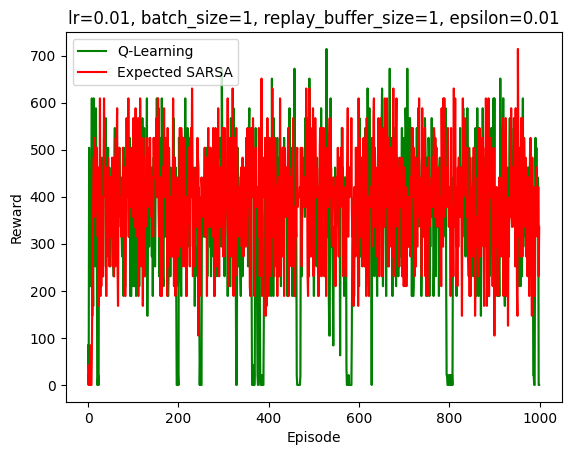

0.0001 32 1000000 0.25
2
Run 1/2


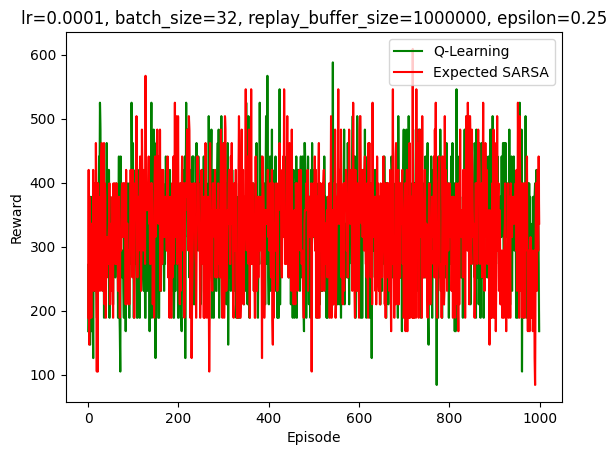

Run 2/2
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 147.0 0.001254403148777783
10 168.0 0.0713086649775505
20 357.0 1.7360020875930786
30 315.0 1.44698166847229
40 273.0 0.1464196890592575
50 210.0 1.0185391902923584
60 315.0 0.12619352340698242
70 231.0 0.17245037853717804
80 189.0 0.37759169936180115
90 399.0 2.2031972408294678
100 189.0 0.258099228143692
110 399.0 1.5295917987823486
120 441.0 0.2950063645839691
130 399.0 0.7727346420288086
140 273.0 0.13900282979011536
150 378.0 1.92433762550354
160 252.0 1.232604742050171
170 126.0 1.6655105352401733
180 483.0 0.39762210845947266
190 252.0 1.

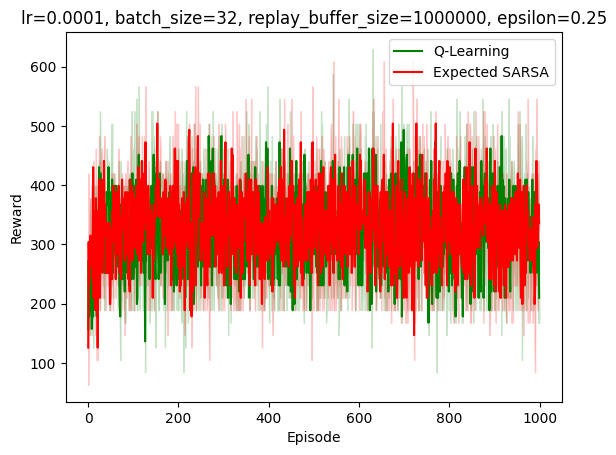

0.0001 32 1000000 0.1
2
Run 1/2


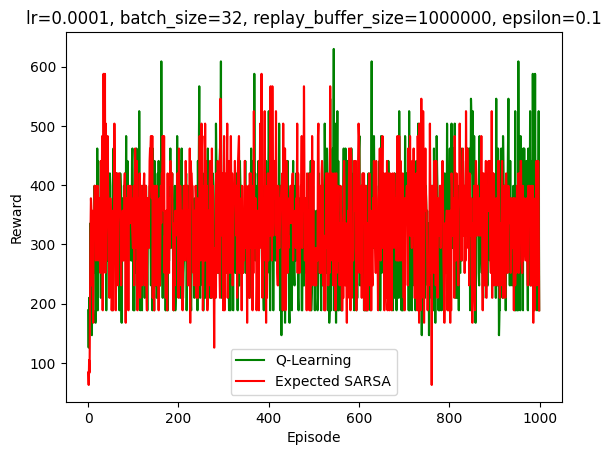

Run 2/2
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 168.0 0.019941477105021477
10 315.0 0.22977860271930695
20 315.0 0.19716928899288177
30 273.0 0.21727430820465088
40 231.0 3.436933755874634
50 294.0 0.9771474003791809
60 336.0 0.21675534546375275
70 378.0 0.456989049911499
80 231.0 1.6912896633148193
90 420.0 1.7413384914398193
100 189.0 0.7507036924362183
110 294.0 4.5514817237854
120 399.0 1.409250020980835
130 420.0 0.8956537842750549
140 336.0 0.8548927307128906
150 210.0 1.7061713933944702
160 189.0 0.46649810671806335
170 378.0 1.9193954467773438
180 210.0 0.4243432581424713
190 378.0 0.

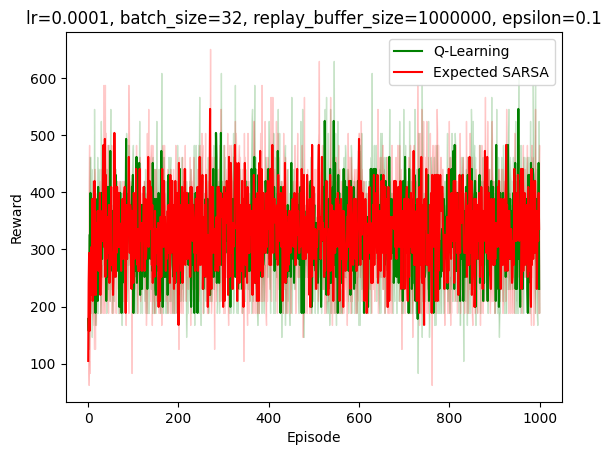

0.0001 32 1000000 0.01
2
Run 1/2


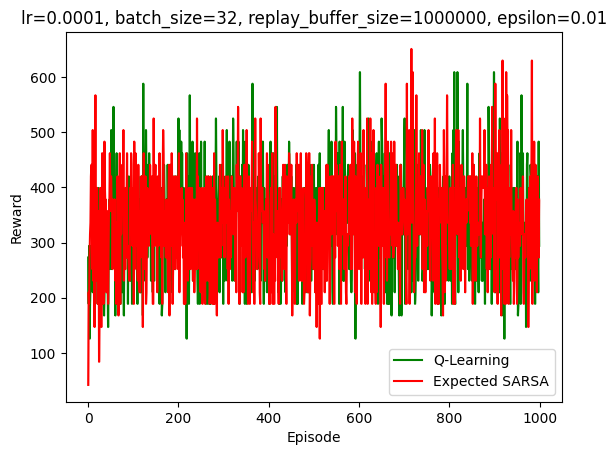

Run 2/2
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 546.0 0.008932949975132942
10 357.0 0.9996143579483032
20 315.0 0.1916583925485611
30 252.0 1.3477872610092163
40 378.0 1.2882148027420044
50 357.0 0.24459891021251678
60 336.0 0.10323568433523178
70 252.0 0.17504039406776428
80 378.0 0.1333964616060257
90 252.0 0.6033616662025452
100 273.0 1.6034036874771118
110 357.0 0.07502005249261856
120 273.0 0.1243898794054985
130 231.0 1.0852327346801758
140 420.0 0.2176048904657364
150 189.0 0.2087259590625763
160 525.0 0.16046364605426788
170 441.0 0.17367124557495117
180 294.0 0.7839410901069641
190 2

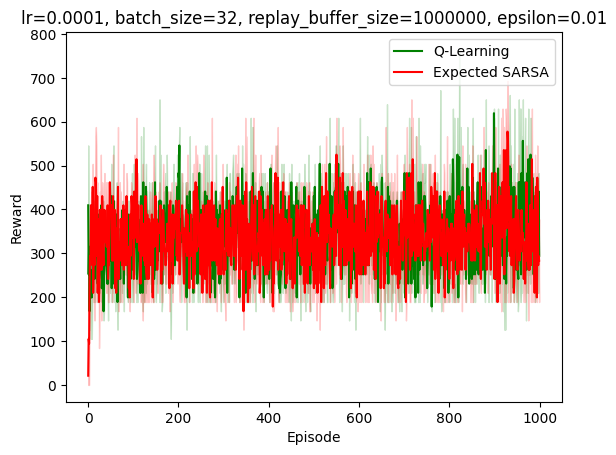

0.001 32 1000000 0.25
2
Run 1/2


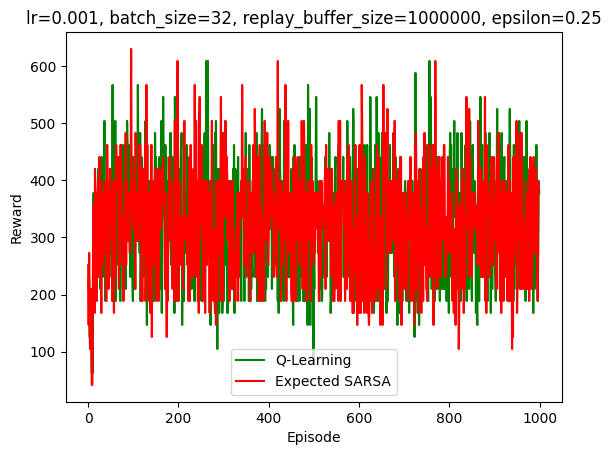

Run 2/2
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 210.0 0.012172780930995941
10 210.0 0.18071439862251282
20 231.0 1.5371249914169312
30 210.0 0.3272283971309662
40 462.0 0.30849477648735046
50 294.0 0.06788846105337143
60 294.0 0.13293729722499847
70 252.0 1.2019774913787842
80 378.0 1.5218693017959595
90 399.0 0.2607489228248596
100 210.0 2.692737102508545
110 336.0 0.2959745526313782
120 315.0 0.04645150899887085
130 378.0 1.4751516580581665
140 462.0 1.2689158916473389
150 231.0 0.21840126812458038
160 483.0 0.9451885223388672
170 336.0 0.10106374323368073
180 420.0 1.7919517755508423
190 3

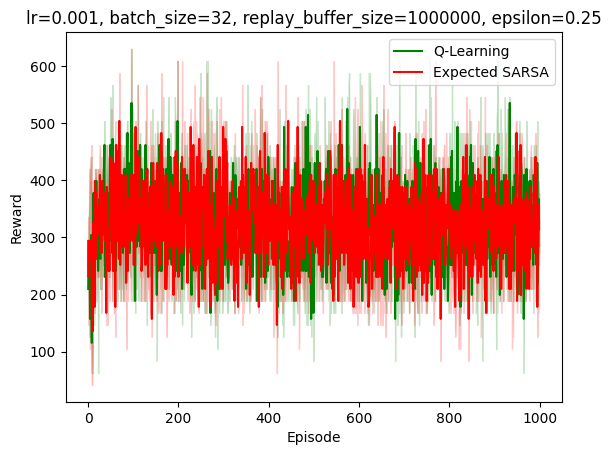

0.001 32 1000000 0.1
2
Run 1/2


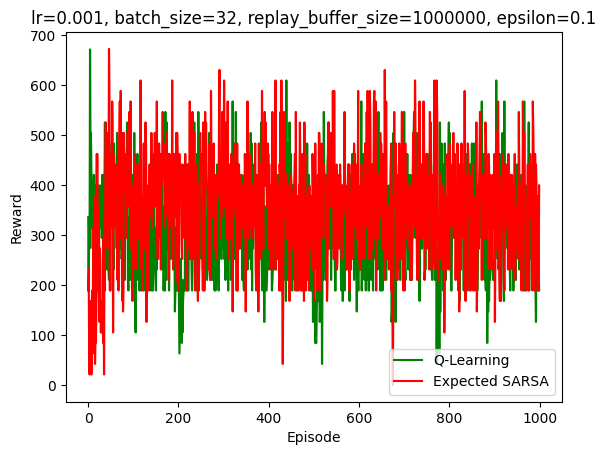

Run 2/2
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 399.0 0.00789558608084917
10 294.0 0.020739134401082993
20 294.0 1.8831218481063843
30 441.0 1.8942620754241943
40 189.0 1.8863385915756226
50 420.0 0.04983028024435043
60 378.0 1.89261794090271
70 357.0 1.894620656967163
80 420.0 1.892687201499939
90 504.0 1.8908510208129883
100 483.0 2.0855231285095215
110 294.0 1.9017382860183716
120 189.0 4.007351875305176
130 378.0 3.743412733078003
140 357.0 1.8986866474151611
150 483.0 1.903959035873413
160 189.0 5.663047790527344
170 210.0 0.0556366853415966
180 378.0 1.9072520732879639
190 483.0 1.89541

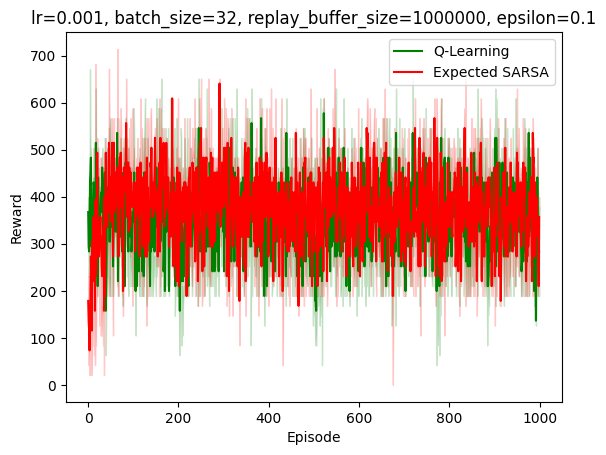

0.001 32 1000000 0.01
2
Run 1/2


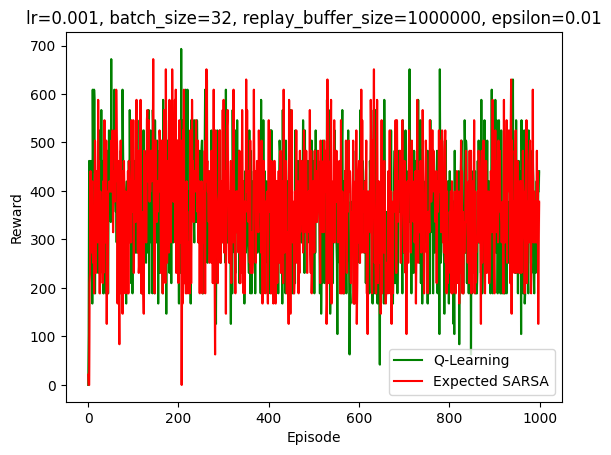

Run 2/2
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 105.0 2.1232608560239896e-05
10 504.0 0.809162974357605
20 378.0 3.743034839630127
30 315.0 0.050950437784194946
40 441.0 0.05201137810945511
50 378.0 0.06804896146059036
60 504.0 3.7515628337860107
70 441.0 1.896314263343811
80 399.0 0.06646959483623505
90 147.0 3.7467808723449707
100 441.0 0.0498494915664196
110 357.0 1.9025670289993286
120 399.0 9.329252243041992
130 273.0 0.07142423093318939
140 378.0 1.905395269393921
150 315.0 3.747403860092163
160 441.0 3.7584986686706543
170 189.0 0.6596280336380005
180 336.0 1.8996856212615967
190 546.0

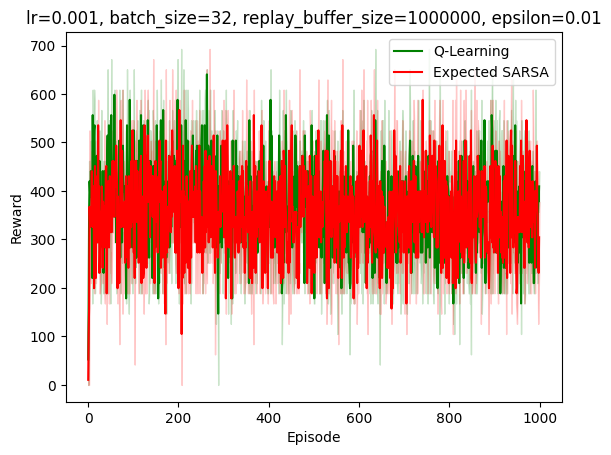

0.01 32 1000000 0.25
2
Run 1/2


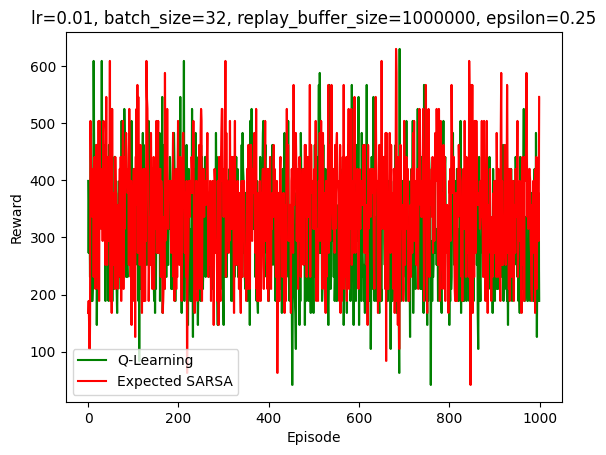

Run 2/2
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 420.0 0.030928466469049454
10 273.0 0.03878975287079811
20 483.0 0.03464769199490547
30 252.0 0.06415185332298279
40 336.0 1.8924669027328491
50 252.0 0.0442487895488739
60 315.0 0.03954838961362839
70 462.0 1.8927935361862183
80 609.0 1.8884419202804565
90 357.0 1.8844064474105835
100 231.0 0.04463762417435646
110 294.0 0.03933892771601677
120 210.0 3.767437219619751
130 315.0 0.012215661816298962
140 210.0 0.04764120653271675
150 294.0 1.9077959060668945
160 336.0 1.9502575397491455
170 315.0 1.9824450016021729
180 378.0 3.7919864654541016
190

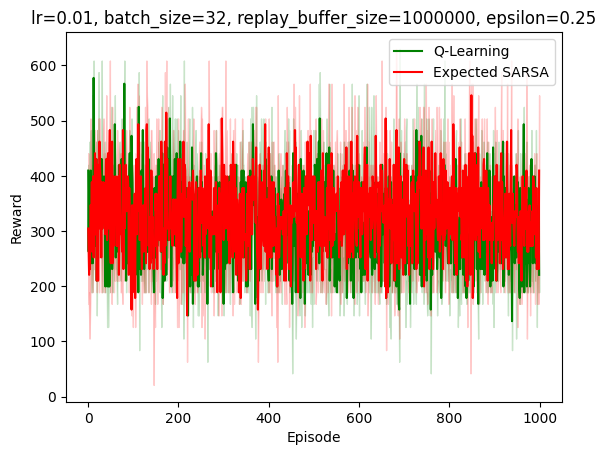

0.01 32 1000000 0.1
2
Run 1/2


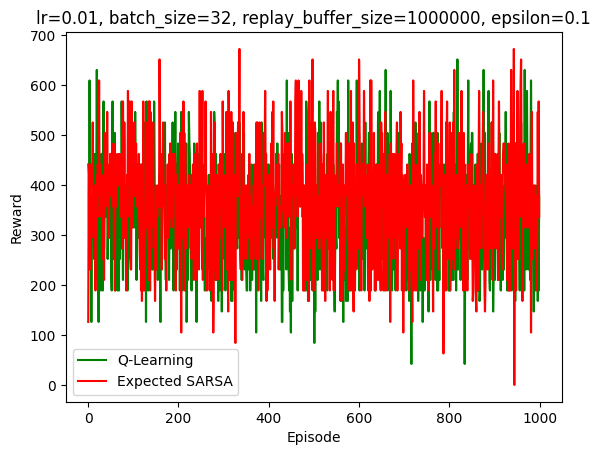

Run 2/2
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 63.0 0.0009365965379402041
10 84.0 0.001005610916763544
20 105.0 0.001508550951257348
30 210.0 0.00376595975831151
40 231.0 0.00785213615745306
50 441.0 0.013842696323990822
60 399.0 0.027772268280386925
70 315.0 0.021093307062983513
80 462.0 1.870274543762207
90 420.0 0.04407966881990433
100 441.0 3.742479085922241
110 378.0 0.0351555161178112
120 231.0 0.040871139615774155
130 420.0 1.8849893808364868
140 189.0 0.029813524335622787
150 462.0 1.8783010244369507
160 420.0 1.8770525455474854
170 273.0 1.8842517137527466
180 231.0 0.03908911347389

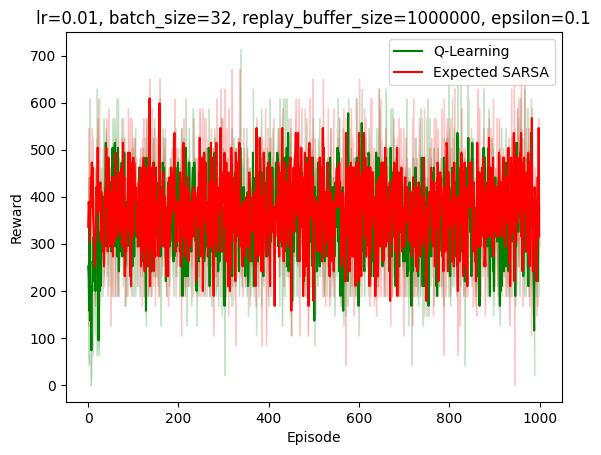

0.01 32 1000000 0.01
2
Run 1/2


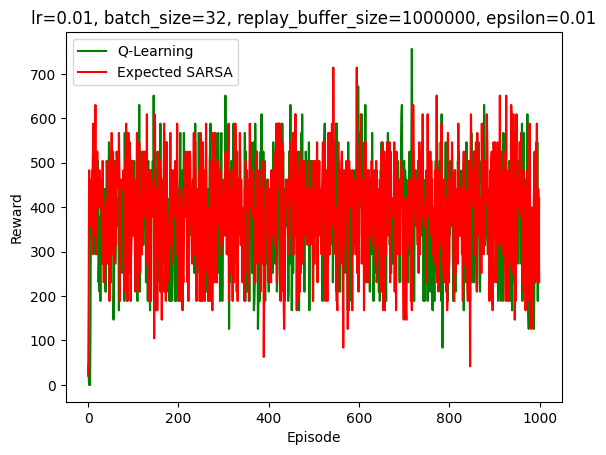

Run 2/2
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 0.0 1.1023098522855435e-05
10 399.0 0.016374880447983742
20 210.0 0.03455829992890358
30 504.0 3.742746591567993
40 315.0 3.737654209136963
50 525.0 0.05504284054040909
60 462.0 3.7475883960723877
70 252.0 1.9008995294570923
80 420.0 0.06406626850366592
90 189.0 0.05454699322581291
100 231.0 0.07342592626810074
110 399.0 3.745124340057373
120 399.0 1.9066115617752075
130 399.0 0.051823973655700684
140 441.0 1.9032260179519653
150 399.0 0.08783560991287231
160 273.0 1.9074984788894653
170 483.0 3.739189624786377
180 420.0 3.749661922454834
190 52

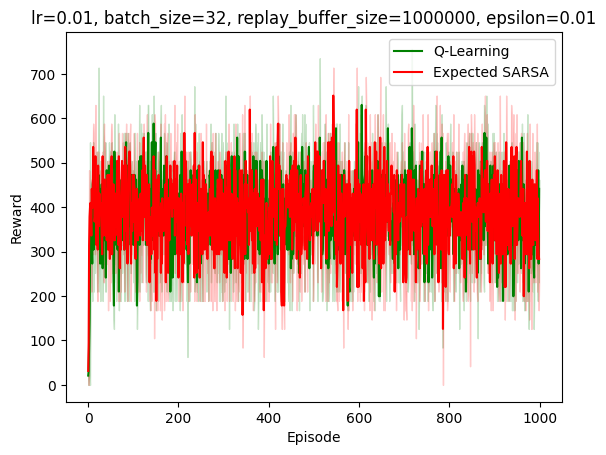

0.0001 1 1 0.25
2
Run 1/2


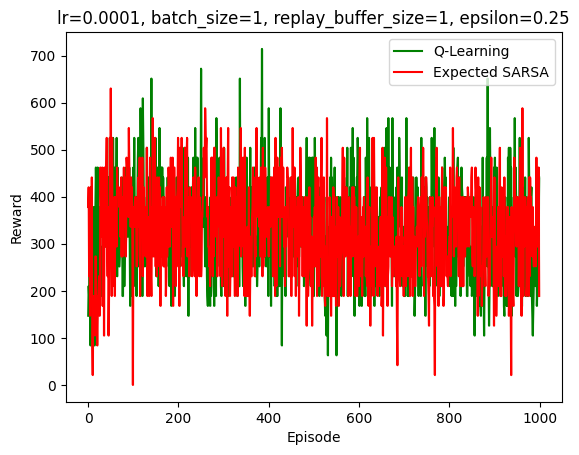

Run 2/2
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 252.0 0.01860879920423031
10 189.0 0.00985853374004364
20 336.0 0.008273695595562458
30 483.0 0.05151238664984703
40 357.0 0.12920886278152466
50 504.0 0.4216381013393402
60 336.0 0.45873790979385376
70 420.0 0.4716874957084656
80 273.0 0.13110294938087463
90 483.0 0.9431509971618652
100 420.0 2.309530735015869
110 294.0 2.20464825630188
120 399.0 2.467055559158325
130 357.0 15.807324409484863
140 399.0 2.062823534011841
150 252.0 16.141895294189453
160 357.0 27.075973510742188
170 483.0 17.925006866455078
180 252.0 25.127229690551758
190 420.0 

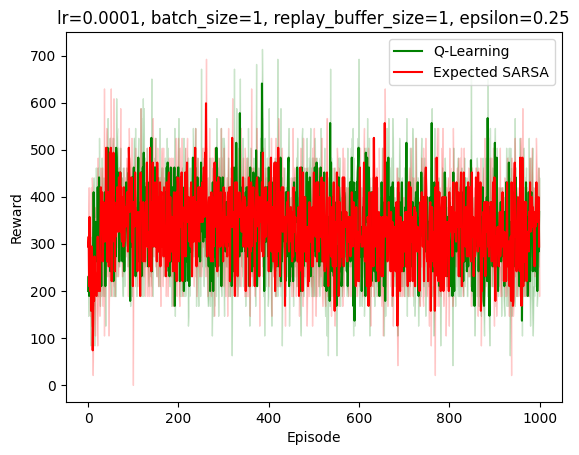

0.0001 1 1 0.1
2
Run 1/2


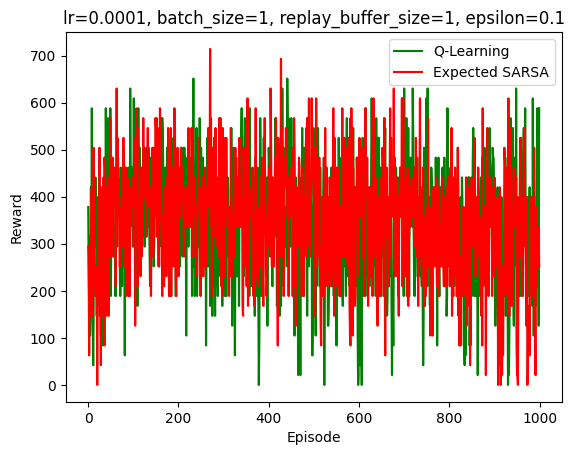

Run 2/2
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 189.0 0.00031890455284155905
10 105.0 0.00029944206471554935
20 189.0 0.0004425985680427402
30 126.0 0.00041249938658438623
40 420.0 0.02751954458653927
50 294.0 0.0030178481247276068
60 483.0 0.055721379816532135
70 483.0 0.19427630305290222
80 399.0 0.07081929594278336
90 420.0 1.2821472883224487
100 441.0 1.4955551624298096
110 546.0 1.685970664024353
120 420.0 2.5363972187042236
130 252.0 1.5597978830337524
140 399.0 0.06727243214845657
150 378.0 0.8047953248023987
160 168.0 3.088793992996216
170 399.0 0.2562369406223297
180 483.0 3.29503440

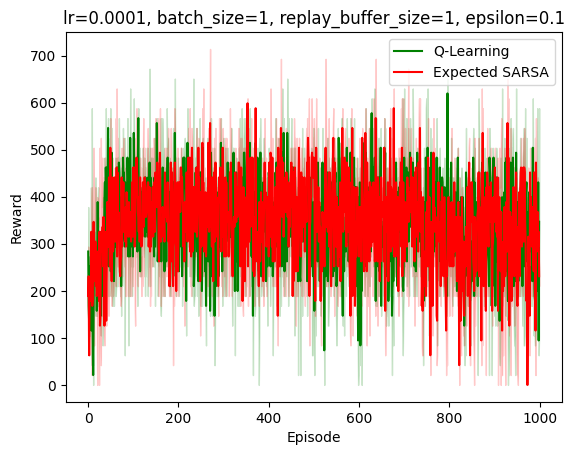

0.0001 1 1 0.01
2
Run 1/2


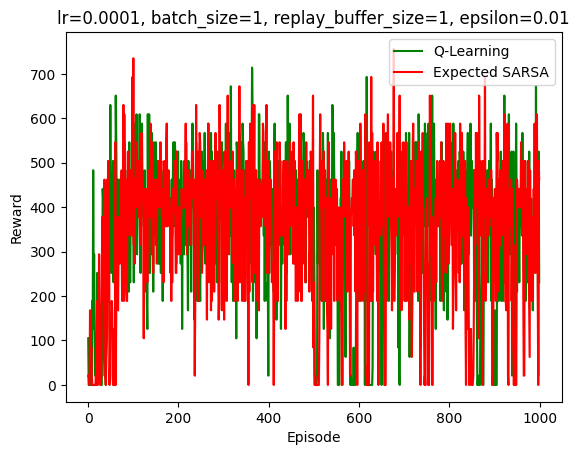

Run 2/2
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 0.0 0.000900749524589628
10 0.0 0.000613397394772619
20 0.0 0.0006077868747524917
30 0.0 0.0004898791084997356
40 63.0 0.00017183877935167402
50 399.0 0.01743886061012745
60 315.0 0.05053015798330307
70 0.0 0.13858112692832947
80 357.0 0.19114504754543304
90 0.0 0.325884610414505
100 315.0 0.21677757799625397
110 231.0 0.43315330147743225
120 588.0 0.10412155836820602
130 315.0 0.4466314911842346
140 588.0 0.4909570813179016
150 399.0 0.10445228964090347
160 462.0 2.1382248401641846
170 420.0 3.1972906589508057
180 588.0 0.18845117092132568
190 

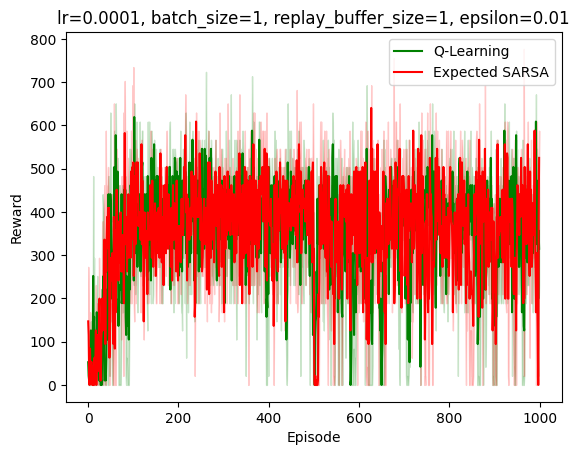

0.001 1 1 0.25
2
Run 1/2


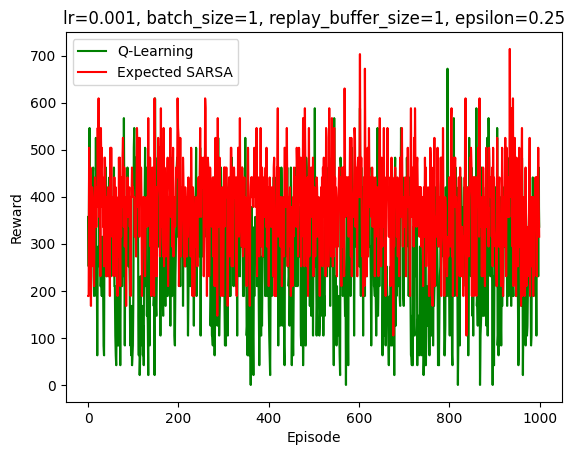

Run 2/2
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 273.0 0.0013776948908343911
10 378.0 0.06712016463279724
20 189.0 0.17152807116508484
30 399.0 0.16926608979701996
40 231.0 0.09715807437896729
50 126.0 0.12653985619544983
60 357.0 0.28036007285118103
70 189.0 0.5704818367958069
80 504.0 0.6844649910926819
90 189.0 1.049062967300415
100 441.0 1.495155930519104
110 399.0 2.0559775829315186
120 357.0 2.7401740550994873
130 357.0 3.4175684452056885
140 168.0 3.3525211811065674
150 126.0 4.083459377288818
160 231.0 4.7060065269470215
170 315.0 5.815949440002441
180 315.0 5.936873912811279
190 273.0

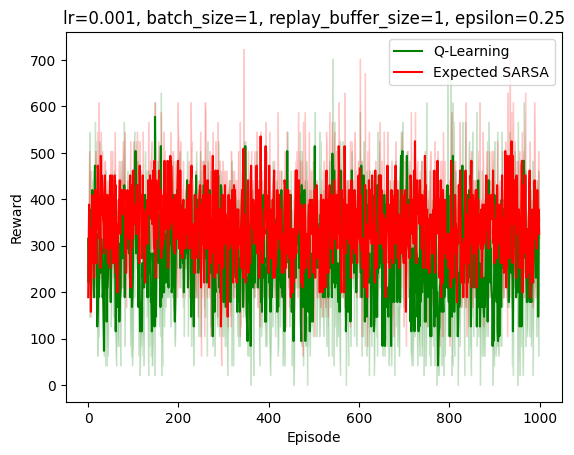

0.001 1 1 0.1
2
Run 1/2


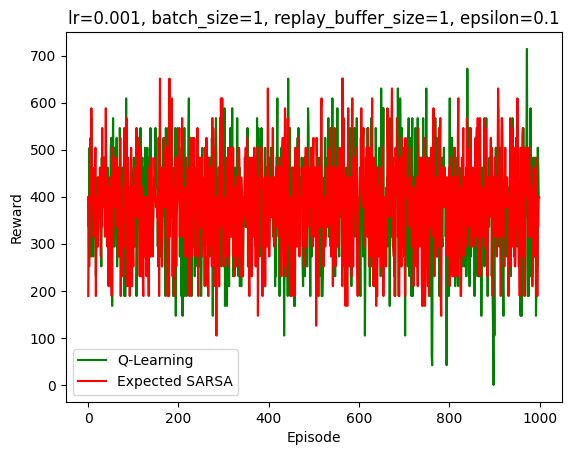

Run 2/2
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 210.0 0.0005517819081433117
10 189.0 0.009204418398439884
20 420.0 0.0386725589632988
30 399.0 0.2764483392238617
40 210.0 0.48982271552085876
50 294.0 0.7665843367576599
60 294.0 1.2517825365066528
70 546.0 1.7152570486068726
80 231.0 2.234064817428589
90 441.0 3.2385241985321045
100 462.0 3.964564561843872
110 210.0 4.586826324462891
120 315.0 5.4737091064453125
130 441.0 6.579399585723877
140 315.0 6.486144065856934
150 441.0 8.779760360717773
160 378.0 10.106528282165527
170 168.0 9.869549751281738
180 336.0 11.230742454528809
190 210.0 11.4

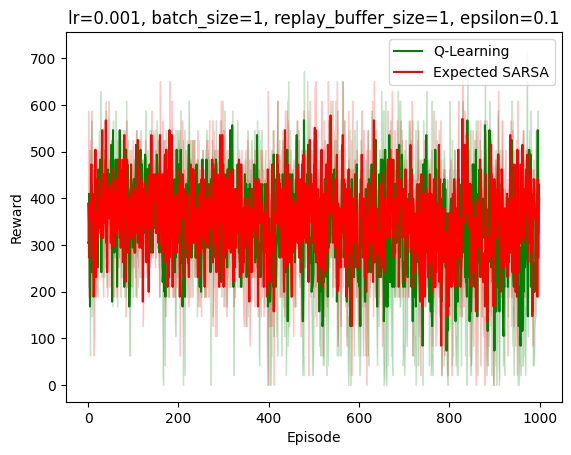

0.001 1 1 0.01
2
Run 1/2


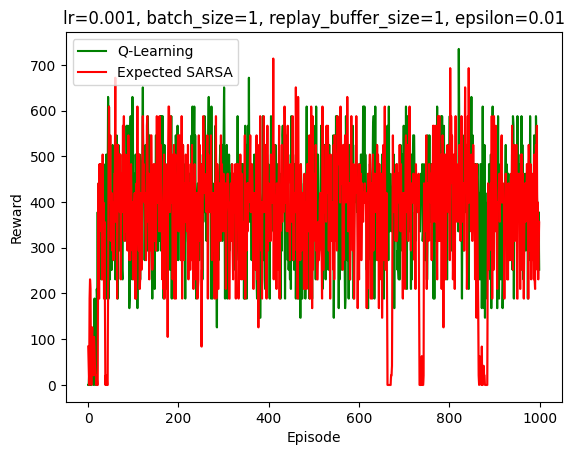

Run 2/2
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 0.0 0.0004665904853027314
10 0.0 0.0004464656230993569
20 252.0 0.000416238239267841
30 0.0 0.0004079127684235573
40 0.0 0.0003994246944785118
50 0.0 0.0004862459027208388
60 63.0 0.0044145421124994755
70 0.0 0.0043183877132833
80 462.0 0.06451878696680069
90 441.0 0.23592586815357208
100 399.0 0.5250539183616638
110 504.0 0.9705764651298523
120 504.0 1.584374189376831
130 483.0 2.3011155128479004
140 441.0 3.1752688884735107
150 315.0 3.7915091514587402
160 189.0 4.123937606811523
170 504.0 5.160876750946045
180 420.0 5.976673126220703
190 441.

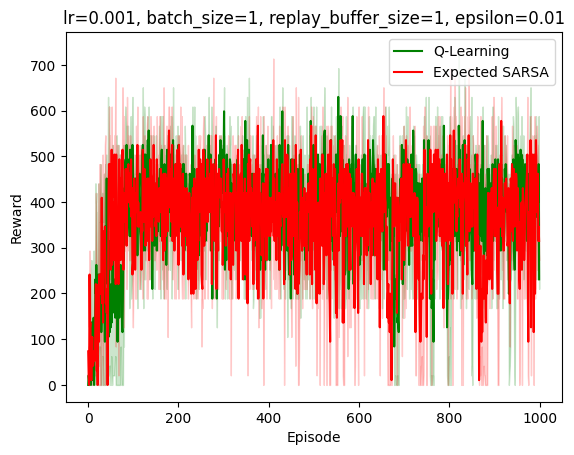

0.01 1 1 0.25
2
Run 1/2


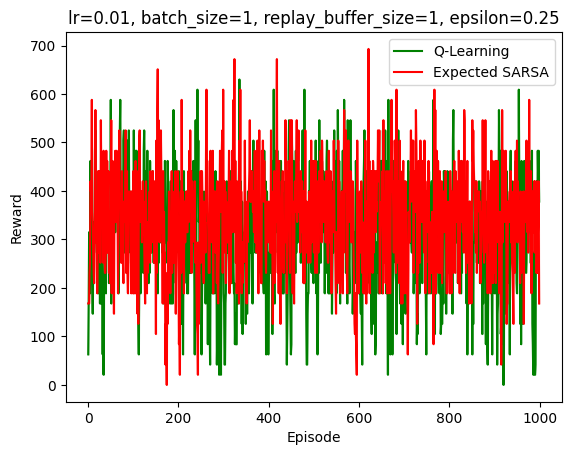

Run 2/2
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 294.0 7.203620771178976e-05
10 420.0 0.07033438235521317
20 63.0 0.17921224236488342
30 315.0 0.2859348952770233
40 336.0 0.3946700990200043
50 420.0 0.6249936819076538
60 210.0 1.0238951444625854
70 378.0 1.1361106634140015
80 189.0 1.7214014530181885
90 294.0 1.8985183238983154


KeyboardInterrupt: 

In [3]:
epsilons = [0.25, 0.1, 0.01]
# lrs = [1/4, 1/8, 1/16]
lrs = [0.0001, 0.001, 0.01]
replay_buffers = [(32, 1000000), (1, 1)]
for i in range(1, 10):
    for replay_buffer in replay_buffers:
        for lr in lrs:
            for epsilon in epsilons:
                print(lr, replay_buffer[0], replay_buffer[1], epsilon)
                run_experiment(lr, replay_buffer[0], replay_buffer[1], epsilon, i)

In [1]:
import numpy as np
np.random.seed()
rand = np.random.randint(0, 1000000)
print(rand)

402622
